In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif,SelectKBest,RFE
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

**training data**

In [2]:
df = pd.read_csv('training_data.csv')
df.drop(columns = ['view_count'],inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1519 entries, 0 to 1518
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   has_photo        1519 non-null   bool   
 1   has_video        1519 non-null   bool   
 2   like_count       1519 non-null   int64  
 3   reply_count      1519 non-null   int64  
 4   repost_count     1519 non-null   int64  
 5   share_count      1519 non-null   int64  
 6   followers_count  1519 non-null   int64  
 7   emoji_count      1519 non-null   int64  
 8   lang             1519 non-null   object 
 9   post_weekday     1519 non-null   int64  
 10  viral            1519 non-null   int64  
 11  has_question     1519 non-null   bool   
 12  has_exclaim      1519 non-null   bool   
 13  sentiment_score  1519 non-null   float64
 14  sentiment_label  1519 non-null   object 
 15  time_gap         1519 non-null   int64  
 16  time_of_day      1519 non-null   int64  
 17  post_length   

In [3]:
df.fillna(0, inplace=True)

In [4]:
df.isnull().sum()

has_photo          0
has_video          0
like_count         0
reply_count        0
repost_count       0
share_count        0
followers_count    0
emoji_count        0
lang               0
post_weekday       0
viral              0
has_question       0
has_exclaim        0
sentiment_score    0
sentiment_label    0
time_gap           0
time_of_day        0
post_length        0
dtype: int64

In [5]:
df_test = pd.read_csv('test_data.csv')
df_test = df_test.drop(columns=['view_count'])
df_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1519 entries, 0 to 1518
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   has_photo        1519 non-null   bool   
 1   has_video        1519 non-null   bool   
 2   like_count       1519 non-null   int64  
 3   reply_count      1519 non-null   int64  
 4   repost_count     1519 non-null   int64  
 5   share_count      1519 non-null   int64  
 6   followers_count  1519 non-null   int64  
 7   emoji_count      1519 non-null   int64  
 8   lang             1519 non-null   object 
 9   post_weekday     1519 non-null   int64  
 10  viral            1519 non-null   int64  
 11  has_question     1519 non-null   bool   
 12  has_exclaim      1519 non-null   bool   
 13  sentiment_score  1519 non-null   float64
 14  sentiment_label  1519 non-null   object 
 15  time_gap         1519 non-null   int64  
 16  time_of_day      1519 non-null   int64  
 17  post_length   

In [6]:
df_test.isnull().sum()

has_photo          0
has_video          0
like_count         0
reply_count        0
repost_count       0
share_count        0
followers_count    0
emoji_count        0
lang               0
post_weekday       0
viral              0
has_question       0
has_exclaim        0
sentiment_score    0
sentiment_label    0
time_gap           0
time_of_day        0
post_length        0
dtype: int64

In [7]:
#train
list_item = []
for col in df.columns:
    list_item.append([col, df[col].dtype, df[col].isna().sum(),
                      100 * df[col].isna().sum() / len(df[col]),
                      df[col].nunique(), df[col].unique()])
desc_df = pd.DataFrame(data=list_item,
                       columns=['feature', 'data_type', 'null_num', 'null_persen', 'unique_num', 'unique_sample'])
desc_df

,feature,data_type,null_num,null_persen,unique_num,unique_sample
0,has_photo,bool,0,0.0,2,"[False, True]"
1,has_video,bool,0,0.0,2,"[False, True]"
2,like_count,int64,0,0.0,290,"[0, 1, 17000, 3, 9, 5, 2, 13, 113, 33, 90, 10,..."
3,reply_count,int64,0,0.0,81,"[0, 440, 2, 5, 10, 1, 50, 3, 14, 29, 7, 28, 17..."
4,repost_count,int64,0,0.0,103,"[0, 550, 1, 37, 81, 20, 280, 2, 3, 4, 86, 77, ..."
5,share_count,int64,0,0.0,97,"[0, 6655, 1, 13, 3, 145, 5, 9, 47, 2, 42, 23, ..."
6,followers_count,int64,0,0.0,640,"[85, 60, 1, 24, 152, 328, 647, 0, 380, 59, 148..."
7,emoji_count,int64,0,0.0,14,"[0, 3, 2, 4, 6, 1, 5, 10, 7, 12, 13, 23, 14, 11]"
8,lang,object,0,0.0,1,[Ch]
9,post_weekday,int64,0,0.0,7,"[1, 4, 6, 3, 0, 5, 2]"


In [8]:
#test
list_item = []
for col in df_test.columns:
    list_item.append([col, df_test[col].dtype, df_test[col].isna().sum(),
                      100 * df_test[col].isna().sum() / len(df_test[col]),
                      df_test[col].nunique(), df_test[col].unique()])
desc_df_test = pd.DataFrame(data=list_item,
                       columns=['feature', 'data_type', 'null_num', 'null_persen', 'unique_num', 'unique_sample'])
desc_df_test

,feature,data_type,null_num,null_persen,unique_num,unique_sample
0,has_photo,bool,0,0.0,2,"[False, True]"
1,has_video,bool,0,0.0,2,"[False, True]"
2,like_count,int64,0,0.0,285,"[4, 137, 175, 3, 0, 10000, 13, 8, 27, 7, 2, 52..."
3,reply_count,int64,0,0.0,80,"[0, 4, 526, 67, 2, 1, 3, 32, 6, 9, 16, 51, 7, ..."
4,repost_count,int64,0,0.0,102,"[0, 2, 8, 1277, 1, 9, 7, 5, 128, 19, 14, 168, ..."
5,share_count,int64,0,0.0,91,"[0, 9, 277, 2, 1, 3, 64, 26, 40, 8, 27, 4, 5, ..."
6,followers_count,int64,0,0.0,623,"[508, 141, 244944, 1, 11, 163550, 245, 131, 22..."
7,emoji_count,int64,0,0.0,13,"[0, 2, 1, 3, 8, 6, 5, 4, 7, 10, 9, 12, 19]"
8,lang,object,0,0.0,1,[Ch]
9,post_weekday,int64,0,0.0,7,"[3, 6, 5, 1, 2, 4, 0]"


In [9]:

# 1. Categorical columns (as DataFrame)
cat_cols = df.select_dtypes(include=['bool', 'object']).columns.tolist()
cat_cols += ['time_of_day', 'post_weekday','viral']
thread_cat = df[cat_cols]

# 2. Numeric columns (as DataFrame, excluding time_of_day and post_weekday)
num_cols = df.select_dtypes(include='number').columns.tolist()
num_cols = [col for col in num_cols if col not in ['time_of_day', 'post_weekday','viral']]
thread_nums = df[num_cols]



**Exploratory Data Analysis**

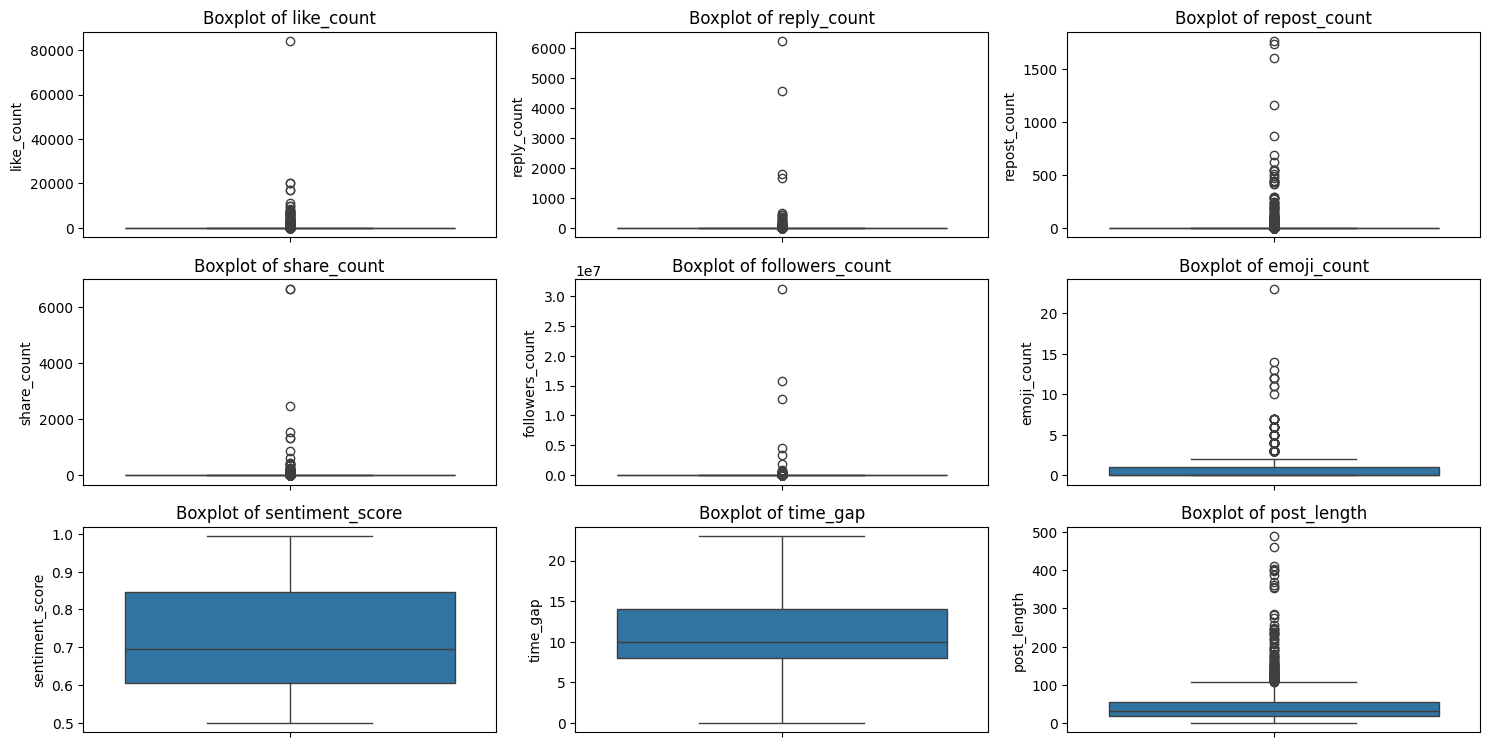

In [10]:

plt.figure(figsize=(15, 10))

for i, column in enumerate(thread_nums):
    plt.subplot(len(thread_nums.columns)//3 + 1, 3, i + 1)
    sns.boxplot(data=df , y=column)
    plt.title(f'Boxplot of {column}')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

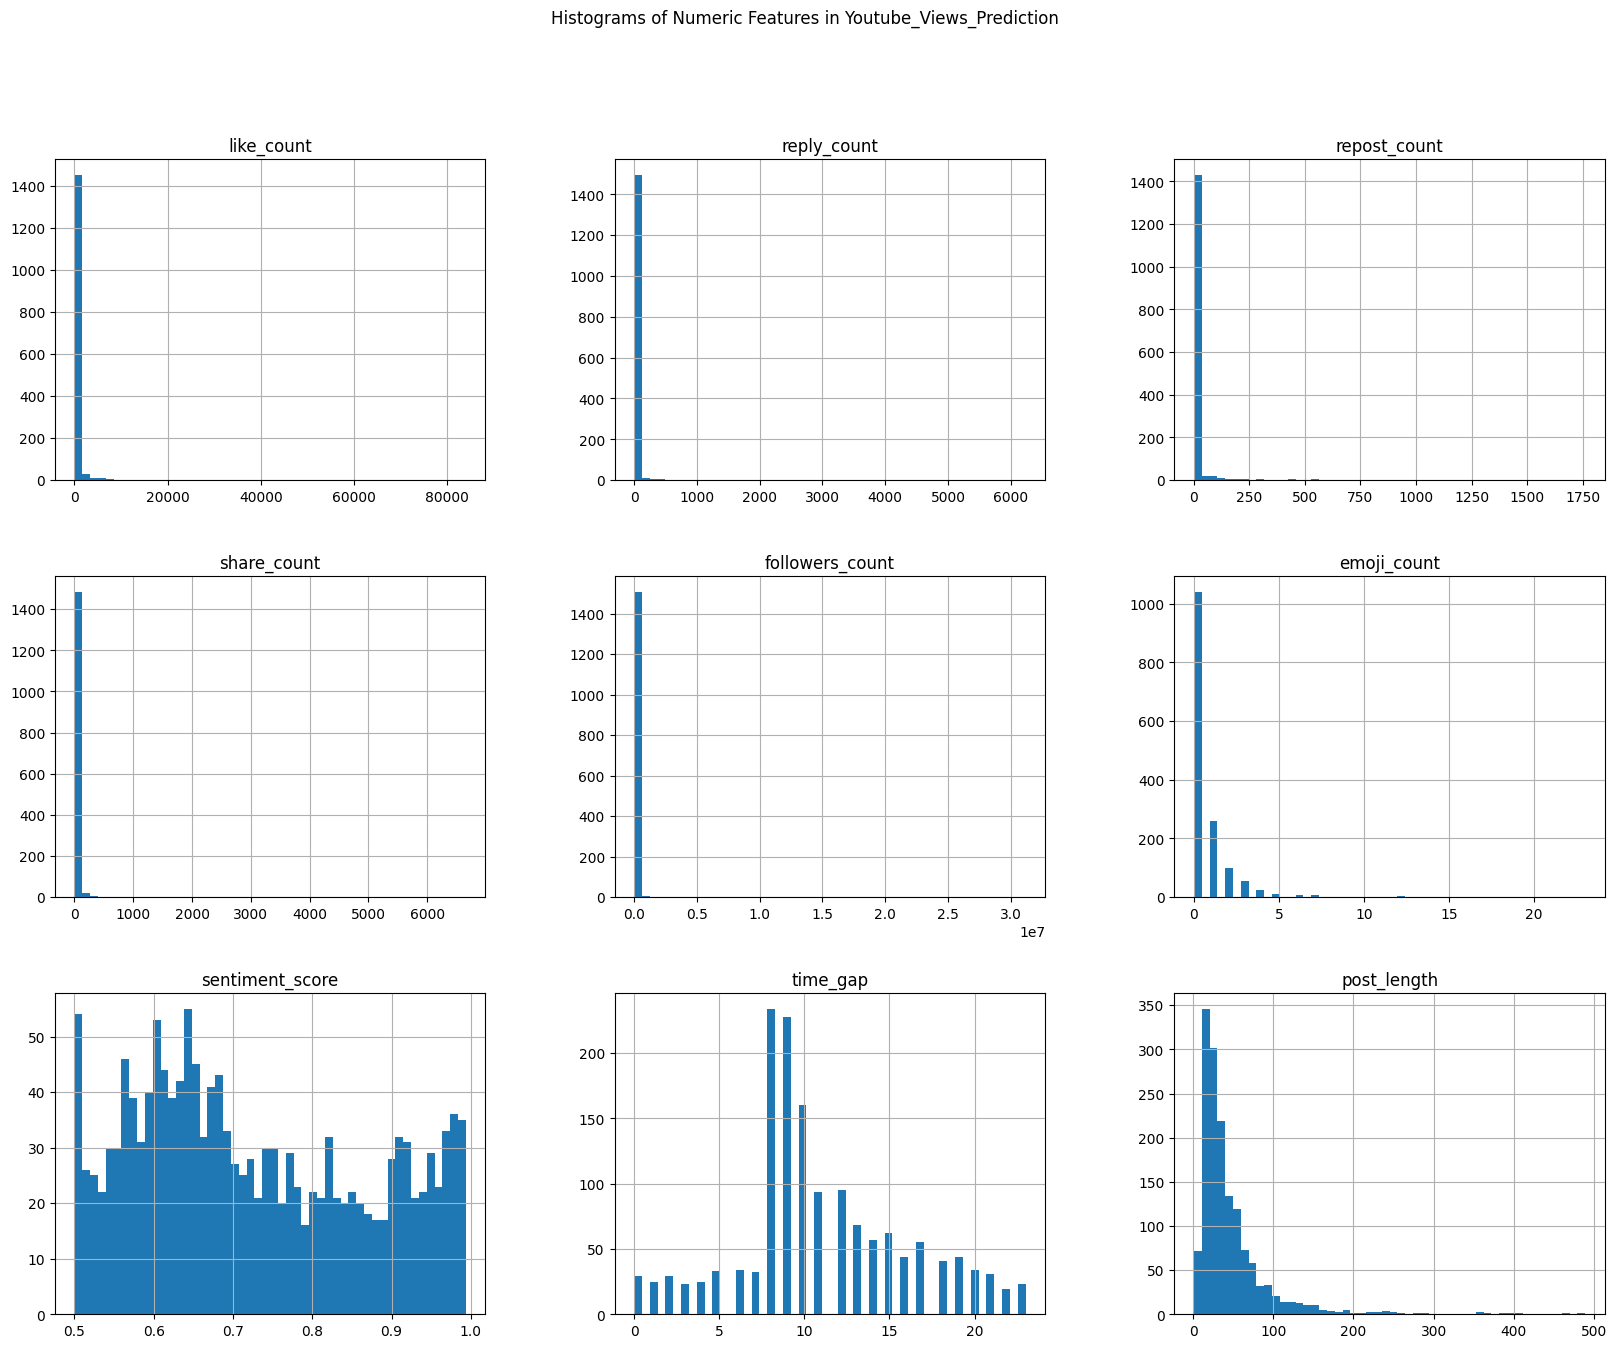

In [11]:
# Plot distribution of each numeric feature (histogram)
thread_nums.hist(bins=50, figsize=(20, 15))
plt.suptitle('Histograms of Numeric Features in Youtube_Views_Prediction')
plt.show()

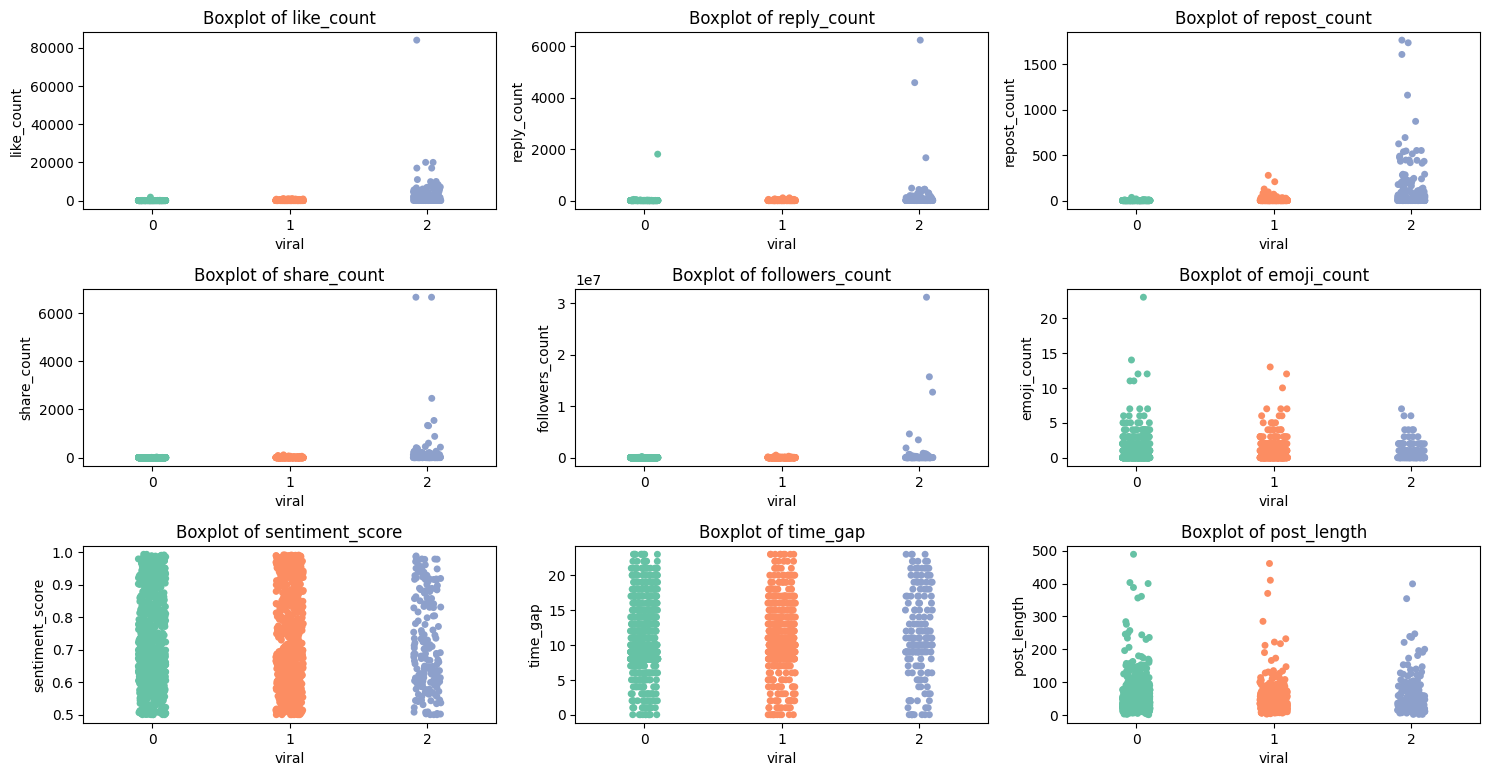

In [12]:
plt.figure(figsize=(15, 10))

for i, column in enumerate(thread_nums):
    plt.subplot(len(thread_nums .columns)//3 + 1, 3, i + 1)
    sns.stripplot(x='viral', y=column, data=df, jitter=True, palette='Set2')
    plt.title(f'Boxplot of {column}')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

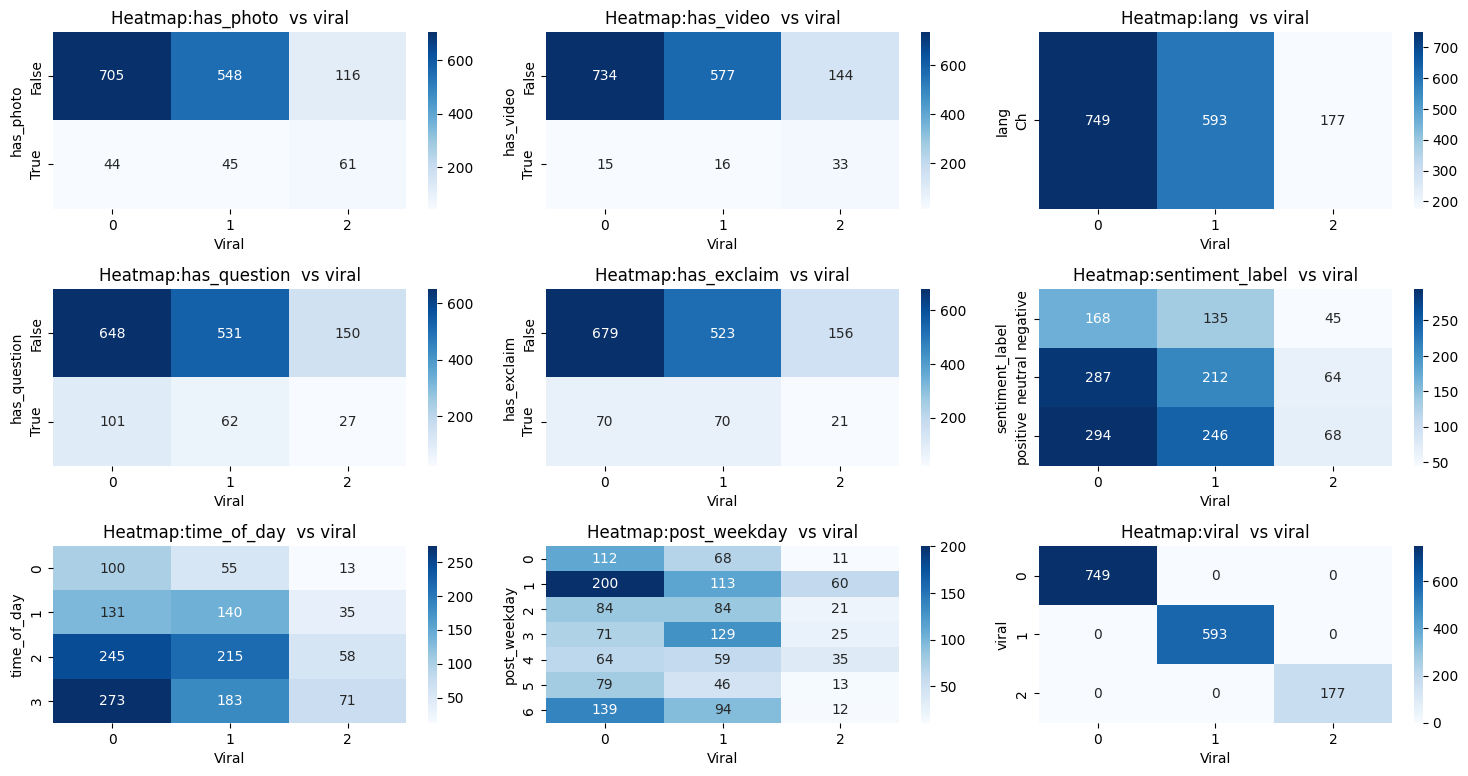

In [13]:

plt.figure(figsize=(15, 10))
for i,column in enumerate(thread_cat):
    ct = pd.crosstab(df[column], df['viral'])
    plt.subplot(len(thread_cat.columns)//3 + 1, 3, i + 1)
    # Plot heatmap
    sns.heatmap(ct, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Heatmap:{column}  vs viral')
    plt.xlabel('Viral')
    plt.ylabel(column)
plt.tight_layout()
plt.show()

**Feature transformation**

In [14]:
cols_to_log = [
    'like_count',
    'reply_count',
    'repost_count',
    'share_count',
    'followers_count',
    'emoji_count',
    'post_length'
]

for col in cols_to_log:
    df[col] = np.log1p(df[col])
    df_test[col] = np.log1p(df_test[col])

    
df

,has_photo,has_video,like_count,reply_count,repost_count,share_count,followers_count,emoji_count,lang,post_weekday,viral,has_question,has_exclaim,sentiment_score,sentiment_label,time_gap,time_of_day,post_length
0,False,False,0.000000,0.000000,0.000000,0.000000,4.454347,0.000000,Ch,1,0,False,False,0.699362,neutral,21,3,3.295837
1,True,False,0.000000,0.000000,0.000000,0.000000,4.110874,0.000000,Ch,4,0,False,False,0.904839,positive,9,3,5.963579
2,False,False,0.000000,0.000000,0.000000,0.000000,0.693147,1.386294,Ch,6,0,False,False,0.648600,neutral,9,3,3.044522
3,False,False,0.693147,0.000000,0.000000,0.000000,3.218876,0.000000,Ch,3,1,False,False,0.745636,neutral,9,1,2.772589
4,False,False,0.000000,0.000000,0.000000,0.000000,0.693147,0.000000,Ch,3,0,False,False,0.954807,positive,16,0,3.526361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1514,False,False,3.637586,0.000000,0.000000,0.000000,9.188401,1.386294,Ch,3,2,True,False,0.555900,negative,11,2,4.174387
1515,False,False,6.572283,1.791759,3.784190,2.197225,8.468633,0.000000,Ch,2,1,False,False,0.647846,neutral,23,0,4.510860
1516,False,False,1.098612,1.098612,0.000000,0.000000,2.564949,0.693147,Ch,2,0,False,False,0.685300,neutral,11,2,3.433987
1517,False,False,0.693147,0.000000,0.000000,0.000000,1.791759,0.000000,Ch,3,0,True,False,0.792375,positive,8,1,4.430817


**Feature Engineering**

In [15]:
for dataset in [df, df_test]:
    # Sentiment features
    dataset['sentiment_like'] = dataset['sentiment_score'] * dataset['like_count']
    dataset['sentiment_reply'] = dataset['sentiment_score'] * dataset['reply_count']
    dataset['sentiment_repost'] = dataset['sentiment_score'] * dataset['repost_count']
    dataset['sentiment_share'] = dataset['sentiment_score'] * dataset['share_count']
    dataset['sentiment_emoji'] = dataset['sentiment_score'] * dataset['emoji_count']

    # Time gap interaction features
    dataset['timeGap_like'] = dataset['time_gap'] * dataset['like_count']
    dataset['timeGap_reply'] = dataset['time_gap'] * dataset['reply_count']
    dataset['timeGap_repost'] = dataset['time_gap'] * dataset['repost_count']
    dataset['timeGap_share'] = dataset['time_gap'] * dataset['share_count']

    # Photo/video interaction features
    dataset['has_photo_video_like'] = (dataset['has_photo'] + 1) * (dataset['has_video'] + 1) * dataset['like_count']
    dataset['has_photo_video_reply'] = (dataset['has_photo'] + 1) * (dataset['has_video'] + 1) * dataset['reply_count']
    dataset['has_photo_video_repost'] = (dataset['has_photo'] + 1) * (dataset['has_video'] + 1) * dataset['repost_count']
    dataset['has_photo_video_share'] = (dataset['has_photo'] + 1) * (dataset['has_video'] + 1) * dataset['share_count']

    # Ratio features
    dataset['like_followers_ratio'] = dataset['like_count'] / (dataset['followers_count'] + 1)
    dataset['reply_followers_ratio'] = dataset['reply_count'] / (dataset['followers_count'] + 1)
    dataset['repost_followers_ratio'] = dataset['repost_count'] / (dataset['followers_count'] + 1)
    dataset['share_followers_ratio'] = dataset['share_count'] / (dataset['followers_count'] + 1)




In [16]:
#encoding 
for col in thread_cat:
    df[col] = LabelEncoder().fit_transform(df[col])
    df_test[col] = LabelEncoder().fit_transform(df_test[col])

In [17]:
X_train = df.drop(columns=['viral'])
y_train = df['viral']

X_test = df_test.drop(columns=['viral'])
y_test = df_test['viral']

In [18]:
X_train.isnull().sum()

has_photo                 0
has_video                 0
like_count                0
reply_count               0
repost_count              0
share_count               0
followers_count           0
emoji_count               0
lang                      0
post_weekday              0
has_question              0
has_exclaim               0
sentiment_score           0
sentiment_label           0
time_gap                  0
time_of_day               0
post_length               0
sentiment_like            0
sentiment_reply           0
sentiment_repost          0
sentiment_share           0
sentiment_emoji           0
timeGap_like              0
timeGap_reply             0
timeGap_repost            0
timeGap_share             0
has_photo_video_like      0
has_photo_video_reply     0
has_photo_video_repost    0
has_photo_video_share     0
like_followers_ratio      0
reply_followers_ratio     0
repost_followers_ratio    0
share_followers_ratio     0
dtype: int64

**Feature Selection**

In [19]:
importance_score_matrix = pd.DataFrame({},index=X_train.columns)

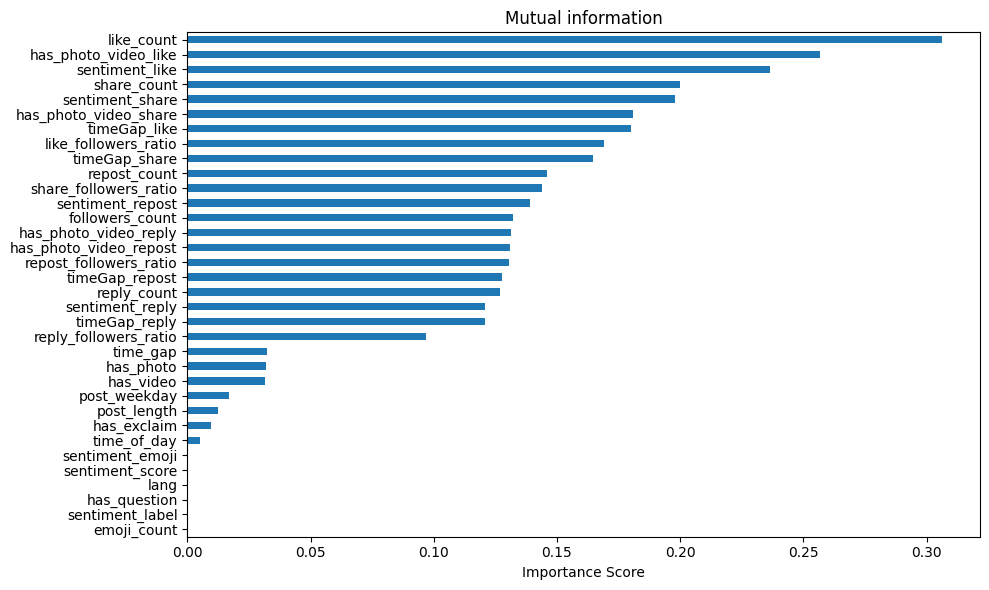

In [20]:
#mutual information 
selector = SelectKBest(mutual_info_classif, k='all')
mi_scores = selector.fit(X_train, y_train).scores_

mi_importances = pd.Series(mi_scores,index=X_train.columns).sort_values(ascending=True)
mi_rank = mi_importances.rank(ascending=False).astype(int)
mi_rank.name = 'MI_Rank'

# Plot the importances
plt.figure(figsize=(10, 6))
mi_importances.plot(kind='barh')
plt.title('Mutual information')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

importance_score_matrix = importance_score_matrix.merge(mi_rank.to_frame(), left_index=True, right_index=True, how='outer')


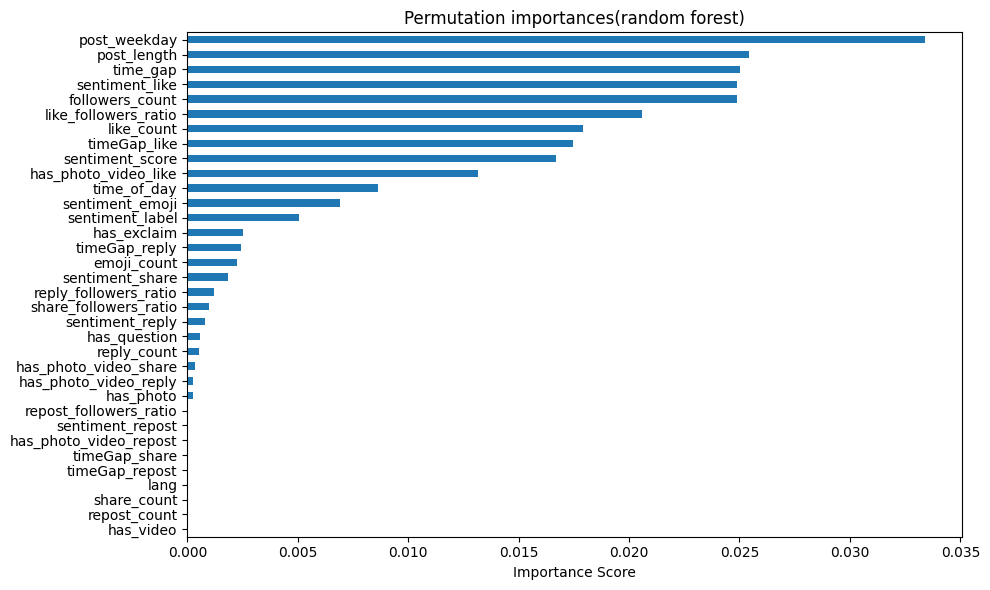

In [21]:
#permutation importances (random forest)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
result = permutation_importance(rf, X_train, y_train, scoring='f1_weighted', n_repeats=10, random_state=42)


perm_scores = result.importances_mean
perm_importances = pd.Series(perm_scores,index=X_train.columns).sort_values(ascending=True)
perm_rank =  perm_importances.rank(ascending=False).astype(int)
perm_rank.name = 'Perm_Rank'

# Plot the importances
plt.figure(figsize=(10, 6))
perm_importances.plot(kind='barh')
plt.title('Permutation importances(random forest)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

importance_score_matrix = importance_score_matrix.merge(perm_rank.to_frame(), left_index=True, right_index=True, how='outer')


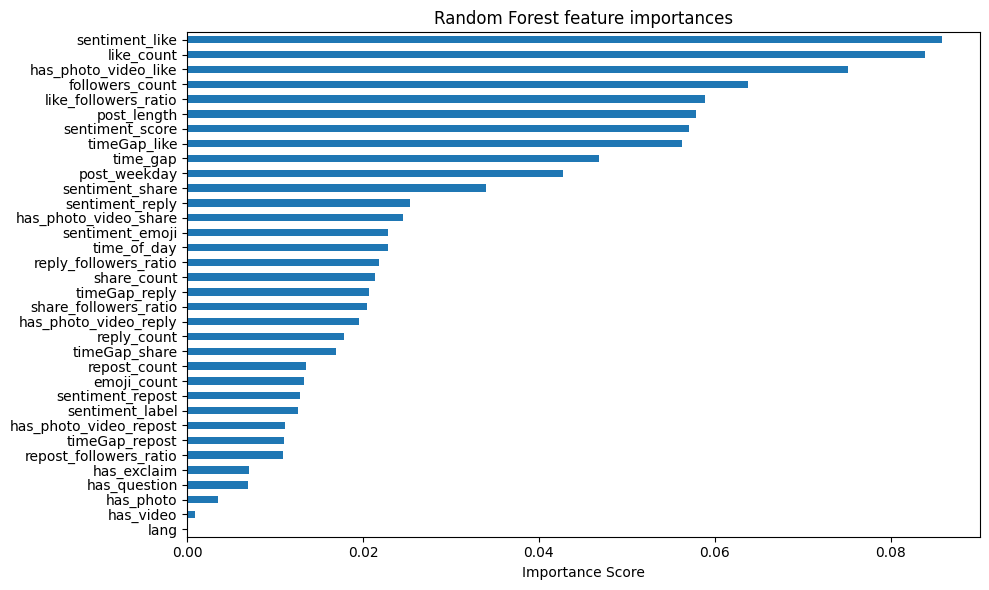

In [22]:
# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Get built-in feature importances 
rf_importances = rf.feature_importances_

# Convert to pandas Series
rf_series = pd.Series(rf_importances, index=X_train.columns).sort_values(ascending=True)

# Create rank
rf_rank = rf_series.rank(ascending=False).astype(int)
rf_rank.name = 'rf_Rank'

# Plot the importances
plt.figure(figsize=(10, 6))
rf_series.plot(kind='barh')
plt.title('Random Forest feature importances')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# Merge into importance score matrix
importance_score_matrix = importance_score_matrix.merge(
    rf_rank.to_frame(),
    left_index=True,
    right_index=True,
    how='outer'
)


In [23]:
# #feature from mi,perm,rf_importances
# mi = list(mi_importances.sort_values(ascending=False)[:22].index)
# perm = list(perm_importances.sort_values(ascending=False) [:14].index)
# rf_importances = list(rf_series.sort_values(ascending=False)[:11].index)

# # Find intersection
# common_features = mi + perm + rf_importances
# common_features = set(common_features)
# common_features

{'followers_count',
 'has_exclaim',
 'has_photo_video_like',
 'has_photo_video_reply',
 'has_photo_video_repost',
 'has_photo_video_share',
 'like_count',
 'like_followers_ratio',
 'post_length',
 'post_weekday',
 'reply_count',
 'reply_followers_ratio',
 'repost_count',
 'repost_followers_ratio',
 'sentiment_emoji',
 'sentiment_label',
 'sentiment_like',
 'sentiment_reply',
 'sentiment_repost',
 'sentiment_score',
 'sentiment_share',
 'share_count',
 'share_followers_ratio',
 'timeGap_like',
 'timeGap_reply',
 'timeGap_repost',
 'timeGap_share',
 'time_gap',
 'time_of_day'}

In [24]:
# importance_score_matrix['min_rank'] = importance_score_matrix[['MI_Rank', 'Perm_Rank', 'rf_Rank']].max(axis=1)
# print(importance_score_matrix)
# feature_ranked = importance_score_matrix['min_rank'].sort_values(ascending=True).index
# feature_ranked

                        MI_Rank  Perm_Rank  rf_Rank  min_rank
emoji_count                  31         16       24        31
followers_count              13          5        4        13
has_exclaim                  27         14       30        30
has_photo                    23         25       32        32
has_photo_video_like          2         10        3        10
has_photo_video_reply        14         24       20        24
has_photo_video_repost       15         30       27        30
has_photo_video_share         6         23       13        23
has_question                 31         21       31        31
has_video                    24         30       33        33
lang                         31         30       34        34
like_count                    1          7        2         7
like_followers_ratio          8          6        5         8
post_length                  26          2        6        26
post_weekday                 25          1       10        25
reply_co

Index(['sentiment_like', 'like_count', 'timeGap_like', 'like_followers_ratio',
       'has_photo_video_like', 'followers_count', 'sentiment_share',
       'share_followers_ratio', 'sentiment_reply', 'timeGap_reply',
       'reply_followers_ratio', 'reply_count', 'time_gap',
       'has_photo_video_share', 'has_photo_video_reply', 'post_weekday',
       'post_length', 'time_of_day', 'timeGap_repost', 'share_count',
       'timeGap_share', 'has_photo_video_repost', 'repost_followers_ratio',
       'sentiment_repost', 'has_exclaim', 'repost_count', 'emoji_count',
       'sentiment_emoji', 'sentiment_score', 'has_question', 'sentiment_label',
       'has_photo', 'has_video', 'lang'],
      dtype='object')

In [25]:
# # Initialize storage lists
# f1_scores = []
# selected_features_list = []

# # Loop through different numbers of top-K features
# for k in range(1, X_train.shape[1] + 1):
#     # Select top-k features using mutual information
#     selector = SelectKBest(score_func=mutual_info_classif, k=k)
#     X_train_selected = selector.fit_transform(X_train, y_train)
#     X_test_selected = selector.transform(X_test)
    
#     # Get selected feature names
#     selected_features = X_train.columns[selector.get_support()].tolist()
    
#     # Train a model on the selected features
#     model = RandomForestClassifier(random_state=42)
#     model.fit(X_train_selected, y_train)
#     y_pred = model.predict(X_test_selected)
    
#     # Evaluate using weighted F1 score
#     score = f1_score(y_test, y_pred, average='weighted')
    
#     # Store the results
#     f1_scores.append(score)
#     selected_features_list.append(selected_features)

# # Save results into a DataFrame
# results_df = pd.DataFrame({
#     "n_features": list(range(1, X_train.shape[1] + 1)),
#     "F1_Score": f1_scores,
#     "Selected_Features": selected_features_list
# })

# best_result = results_df.loc[results_df['F1_Score'].idxmax()]
# best_result

n_features                                                          26
F1_Score                                                      0.693149
Selected_Features    [has_photo, like_count, reply_count, repost_co...
Name: 25, dtype: object

In [26]:
rfe_f1_score_list = []
rfe_feature_list = []

# Total number of features
number_of_features = len(X_train.columns)

# Use RandomForest for feature selection
selector_model = RandomForestClassifier(n_estimators=100, random_state=42)

for k in range(1, number_of_features + 1):
    RFE_selector = RFE(estimator=selector_model, n_features_to_select=k, step=1)
    RFE_selector.fit(X_train, y_train)
    
    sel_X_train_v3 = RFE_selector.transform(X_train)
    sel_X_test_v3 = RFE_selector.transform(X_test)

    # Train Naive Bayes on selected features
    model =  XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    model.fit(sel_X_train_v3, y_train)
    RFE_preds = model.predict(sel_X_test_v3)

    f1_score_rfe = round(f1_score(y_test, RFE_preds, average='weighted'), 3)
    rfe_f1_score_list.append(f1_score_rfe)

    selected_features = X_train.columns[RFE_selector.get_support()].tolist()
    rfe_feature_list.append(selected_features)

# Combine into DataFrame
rfe_summary = pd.DataFrame({
    "n_features": list(range(1, number_of_features + 1)),
    "F1_Score": rfe_f1_score_list,
    "Selected_Features": rfe_feature_list
})

# Get best set of features
best_idx = rfe_summary["F1_Score"].idxmax()
selected_feature_rfe = rfe_summary.loc[best_idx, "Selected_Features"]

selected_feature_rfe

['like_count',
 'reply_count',
 'repost_count',
 'share_count',
 'followers_count',
 'emoji_count',
 'post_weekday',
 'sentiment_score',
 'time_gap',
 'time_of_day',
 'post_length',
 'sentiment_like',
 'sentiment_reply',
 'sentiment_share',
 'sentiment_emoji',
 'timeGap_like',
 'timeGap_reply',
 'timeGap_share',
 'has_photo_video_like',
 'has_photo_video_reply',
 'has_photo_video_share',
 'like_followers_ratio',
 'reply_followers_ratio',
 'share_followers_ratio']

In [27]:

selected_feature = selected_feature_rfe

X_train = X_train[selected_feature]
X_test = X_test[selected_feature]
selected_feature
X_train

,like_count,reply_count,repost_count,share_count,followers_count,emoji_count,post_weekday,sentiment_score,time_gap,time_of_day,...,sentiment_emoji,timeGap_like,timeGap_reply,timeGap_share,has_photo_video_like,has_photo_video_reply,has_photo_video_share,like_followers_ratio,reply_followers_ratio,share_followers_ratio
0,0.000000,0.000000,0.000000,0.000000,4.454347,0.000000,1,0.699362,21,3,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,4.110874,0.000000,4,0.904839,9,3,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.693147,1.386294,6,0.648600,9,3,...,0.899151,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.693147,0.000000,0.000000,0.000000,3.218876,0.000000,3,0.745636,9,1,...,0.000000,6.238325,0.000000,0.000000,0.693147,0.000000,0.000000,0.164297,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.693147,0.000000,3,0.954807,16,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1514,3.637586,0.000000,0.000000,0.000000,9.188401,1.386294,3,0.555900,11,2,...,0.770641,40.013448,0.000000,0.000000,3.637586,0.000000,0.000000,0.357032,0.000000,0.000000
1515,6.572283,1.791759,3.784190,2.197225,8.468633,0.000000,2,0.647846,23,0,...,0.000000,151.162498,41.210468,50.536165,6.572283,1.791759,2.197225,0.694111,0.189231,0.232053
1516,1.098612,1.098612,0.000000,0.000000,2.564949,0.693147,2,0.685300,11,2,...,0.475014,12.084735,12.084735,0.000000,1.098612,1.098612,0.000000,0.308171,0.308171,0.000000
1517,0.693147,0.000000,0.000000,0.000000,1.791759,0.000000,3,0.792375,8,1,...,0.000000,5.545177,0.000000,0.000000,0.693147,0.000000,0.000000,0.248283,0.000000,0.000000


In [28]:
#handle imbalance
smote = SMOTE(random_state=42)
X_train,y_train = smote.fit_resample(X_train,y_train)
y_train.value_counts()

viral
0    749
1    749
2    749
Name: count, dtype: int64


📊 Model: Random Forest
🎯 Weighted F1 Score: 0.6789
              precision    recall  f1-score   support

           0      0.724     0.766     0.744       745
           1      0.609     0.575     0.591       604
           2      0.725     0.682     0.703       170

    accuracy                          0.681      1519
   macro avg      0.686     0.674     0.680      1519
weighted avg      0.678     0.681     0.679      1519



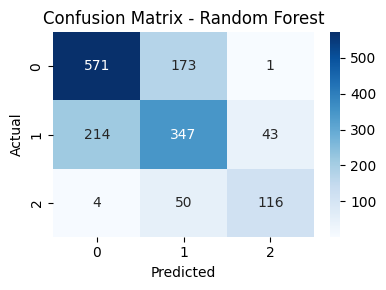


📊 Model: Logistic Regression
🎯 Weighted F1 Score: 0.6437
              precision    recall  f1-score   support

           0      0.719     0.758     0.738       745
           1      0.584     0.480     0.527       604
           2      0.555     0.771     0.645       170

    accuracy                          0.649      1519
   macro avg      0.619     0.670     0.637      1519
weighted avg      0.647     0.649     0.644      1519



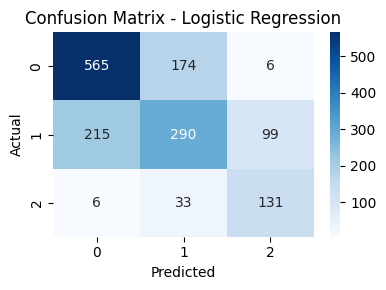


📊 Model: SVM
🎯 Weighted F1 Score: 0.6686
              precision    recall  f1-score   support

           0      0.723     0.770     0.746       745
           1      0.606     0.538     0.570       604
           2      0.646     0.718     0.680       170

    accuracy                          0.672      1519
   macro avg      0.658     0.675     0.665      1519
weighted avg      0.668     0.672     0.669      1519



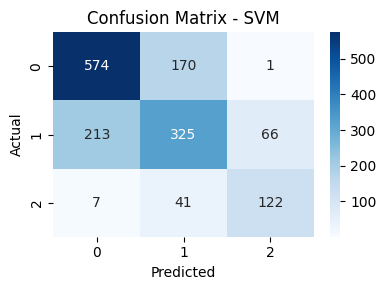


📊 Model: XGBoost
🎯 Weighted F1 Score: 0.6628
              precision    recall  f1-score   support

           0      0.707     0.744     0.725       745
           1      0.588     0.561     0.574       604
           2      0.734     0.682     0.707       170

    accuracy                          0.664      1519
   macro avg      0.676     0.662     0.669      1519
weighted avg      0.662     0.664     0.663      1519



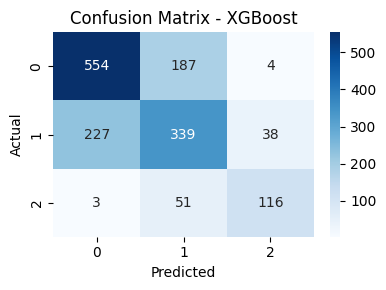


📊 Model: Naive Bayes
🎯 Weighted F1 Score: 0.6052
              precision    recall  f1-score   support

           0      0.644     0.910     0.755       745
           1      0.659     0.291     0.404       604
           2      0.615     0.724     0.665       170

    accuracy                          0.643      1519
   macro avg      0.640     0.642     0.608      1519
weighted avg      0.647     0.643     0.605      1519



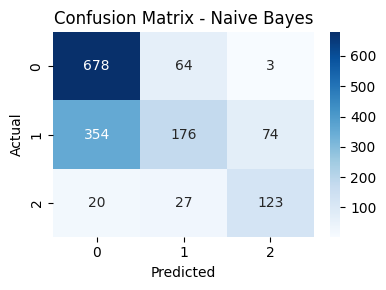

In [29]:
# Define models
models = {
    "Random Forest": RandomForestClassifier( random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC( probability=True, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, random_state=42),
    "Naive Bayes": GaussianNB()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Use weighted F1
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n📊 Model: {name}")
    print(f"🎯 Weighted F1 Score: {f1:.4f}")
    print(classification_report(y_test, y_pred, digits=3))  # prints per-class + weighted + macro

    # Plot confusion matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

**fine-tuning**


🔍 Tuning: Random Forest
✅ Best Params: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': None}
🎯 F1 Score: 0.6740
              precision    recall  f1-score   support

           0       0.72      0.77      0.74       745
           1       0.61      0.56      0.58       604
           2       0.72      0.69      0.70       170

    accuracy                           0.68      1519
   macro avg       0.68      0.67      0.68      1519
weighted avg       0.67      0.68      0.67      1519



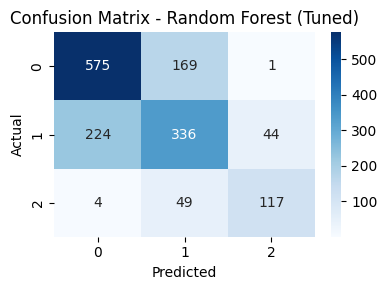


🔍 Tuning: Logistic Regression
✅ Best Params: {'solver': 'lbfgs', 'penalty': 'l2', 'C': np.float64(35.93813663804626)}
🎯 F1 Score: 0.6438
              precision    recall  f1-score   support

           0       0.72      0.76      0.74       745
           1       0.58      0.48      0.53       604
           2       0.55      0.77      0.64       170

    accuracy                           0.65      1519
   macro avg       0.62      0.67      0.64      1519
weighted avg       0.65      0.65      0.64      1519



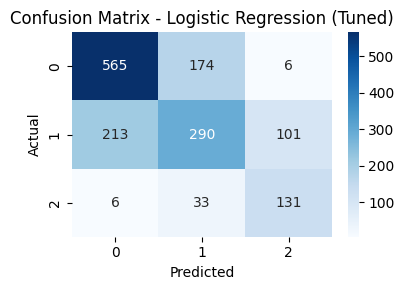


🔍 Tuning: SVM
✅ Best Params: {'kernel': 'rbf', 'gamma': 'auto', 'C': np.float64(100.0)}
🎯 F1 Score: 0.5775
              precision    recall  f1-score   support

           0       0.71      0.65      0.68       745
           1       0.49      0.59      0.53       604
           2       0.36      0.23      0.28       170

    accuracy                           0.58      1519
   macro avg       0.52      0.49      0.50      1519
weighted avg       0.58      0.58      0.58      1519



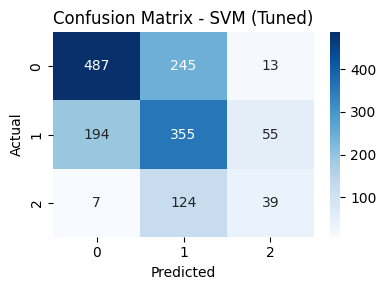


🔍 Tuning: XGBoost
✅ Best Params: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05}
🎯 F1 Score: 0.6889
              precision    recall  f1-score   support

           0       0.73      0.79      0.76       745
           1       0.63      0.57      0.60       604
           2       0.71      0.70      0.71       170

    accuracy                           0.69      1519
   macro avg       0.69      0.69      0.69      1519
weighted avg       0.69      0.69      0.69      1519



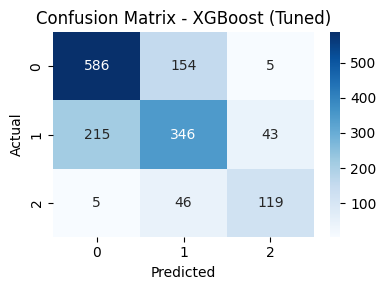


🔍 Tuning: Naive Bayes
🎯 F1 Score: 0.6052
              precision    recall  f1-score   support

           0       0.64      0.91      0.75       745
           1       0.66      0.29      0.40       604
           2       0.61      0.72      0.66       170

    accuracy                           0.64      1519
   macro avg       0.64      0.64      0.61      1519
weighted avg       0.65      0.64      0.61      1519



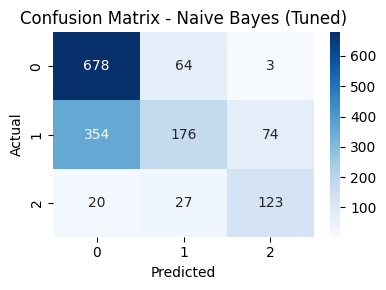

In [30]:

# Scoring
f1_scorer = make_scorer(f1_score, average='weighted')

# Define parameter distributions for randomized search
param_distributions = {
    "Random Forest": {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10]
    },
    "Logistic Regression": {
        "C": np.logspace(-2, 2, 10),
        "penalty": ["l2"],
        "solver": ["lbfgs"]
    },
    "SVM": {
        "C": np.logspace(-2, 2, 10),
        "gamma": ["scale", "auto"],
        "kernel": ["rbf"]
    },
    "XGBoost": {
        "n_estimators": [100, 200, 300],
        "max_depth": [3, 5, 7],
        "learning_rate": [0.01, 0.05, 0.1, 0.2],
        "subsample": [0.8, 1.0]
    },
    "Naive Bayes": {}  # no tuning
}

best_models = {}

for name, model in models.items():
    print(f"\n🔍 Tuning: {name}")
    
    if param_distributions[name]:
        search = RandomizedSearchCV(
            model,
            param_distributions=param_distributions[name],
            n_iter=20,
            scoring=f1_scorer,
            cv=5,
            random_state=42,
            n_jobs=-1
        )
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        print("✅ Best Params:", search.best_params_)
    else:
        model.fit(X_train, y_train)
        best_model = model

    best_models[name] = best_model

    # Predict & evaluate
    y_pred = best_model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)

    print(f"🎯 F1 Score: {f1:.4f}")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f'Confusion Matrix - {name} (Tuned)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()